In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from data import get_data
import matplotlib.pyplot as plt

In [2]:
data =pd.read_csv('XAUUSD.csv')
data

,time,open,high,low,close,tick_volume,MA_daily,MA_weekly,RSI,BB_High,BB_Low,MACD
0,2017-01-31 11:00:00,1198.45,1204.32,1197.53,1204.23,26378,1192.6794,1192.27010,65.694013,1203.664980,1192.537020,2.179186
1,2017-01-31 12:00:00,1204.23,1206.82,1203.68,1204.89,38616,1193.1338,1192.57645,66.653721,1204.512757,1192.861243,2.460562
2,2017-01-31 13:00:00,1204.88,1205.65,1203.27,1204.11,37947,1193.5702,1192.88415,64.362141,1205.260365,1192.700635,2.590749
3,2017-01-31 14:00:00,1204.08,1214.34,1203.94,1212.94,70737,1194.1904,1193.23945,74.887745,1208.366068,1191.385932,3.367612
4,2017-01-31 15:00:00,1212.94,1215.41,1211.77,1212.51,75073,1194.7566,1193.59475,73.745489,1210.654529,1190.619471,3.903585
...,...,...,...,...,...,...,...,...,...,...,...,...
37558,2023-06-15 15:00:00,1953.14,1957.81,1951.95,1956.56,7423,1945.1786,1954.58930,63.967108,1954.626510,1923.696490,-0.000903
37559,2023-06-15 16:00:00,1956.56,1960.20,1956.56,1959.55,5943,1945.1422,1954.65475,66.026741,1957.597705,1922.186295,1.345662
37560,2023-06-15 17:00:00,1959.55,1960.28,1957.71,1958.76,4674,1945.2342,1954.71090,64.970058,1960.234958,1921.203042,2.322307
37561,2023-06-15 18:00:00,1958.78,1959.50,1956.93,1957.52,3697,1945.3326,1954.77385,63.258764,1962.211225,1920.577775,2.962102


In [3]:
# Assume we're going to predict 'high' and 'low' values
target_columns = ['high', 'low']

# Normalize features
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data.drop('time', axis=1)), columns=data.columns[1:])

# Split the data into features (X) and target (y)
X = data_normalized.drop(target_columns, axis=1)
y = data_normalized[target_columns]

class TimeseriesDataset(Dataset):
    def __init__(self, X_data, y_data, sequence_length):
        self.X_data = X_data
        self.y_data = y_data
        self.sequence_length = sequence_length

    def __getitem__(self, index):
        return (self.X_data[index:index+self.sequence_length], self.y_data[index+self.sequence_length])

    def __len__(self):
        return self.X_data.__len__() - self.sequence_length

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Create Dataset
sequence_length = 120
train_data = TimeseriesDataset(torch.tensor(X_train.values).float(), torch.tensor(y_train.values).float(), sequence_length)
test_data = TimeseriesDataset(torch.tensor(X_test.values).float(), torch.tensor(y_test.values).float(), sequence_length)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)



In [15]:

# Define your LSTM Model
class HLmodel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=512, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions


In [16]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your model, criterion, and optimizer
model = HLmodel(input_size=9, output_size=2).to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Epoch 0, Train Loss: 0.355021, Test Loss: 0.109285
Epoch 1, Train Loss: 0.111935, Test Loss: 0.091510
Epoch 2, Train Loss: 0.102602, Test Loss: 0.097673
Epoch 3, Train Loss: 0.098498, Test Loss: 0.090104
Epoch 4, Train Loss: 0.097338, Test Loss: 0.096164
Epoch 5, Train Loss: 0.098330, Test Loss: 0.091710
Epoch 6, Train Loss: 0.095529, Test Loss: 0.092972
Epoch 7, Train Loss: 0.098028, Test Loss: 0.088073
Epoch 8, Train Loss: 0.099893, Test Loss: 0.087744
Epoch 9, Train Loss: 0.097448, Test Loss: 0.120231
Epoch 10, Train Loss: 0.099008, Test Loss: 0.091548
Epoch 11, Train Loss: 0.099828, Test Loss: 0.093748
Epoch 12, Train Loss: 0.100137, Test Loss: 0.088162
Epoch 13, Train Loss: 0.098610, Test Loss: 0.090582
Epoch 14, Train Loss: 0.098493, Test Loss: 0.087892
Epoch 15, Train Loss: 0.100909, Test Loss: 0.099360
Epoch 16, Train Loss: 0.097923, Test Loss: 0.090362
Epoch 17, Train Loss: 0.099147, Test Loss: 0.092167
Epoch 18, Train Loss: 0.101499, Test Loss: 0.091936
Epoch 19, Train Loss: 

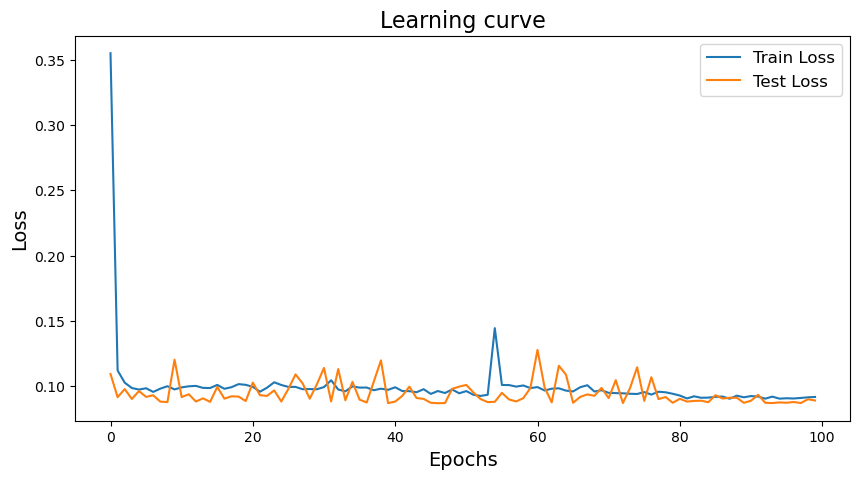

In [18]:

# Training
train_loss_list = []
test_loss_list = []

for epoch in range(100):  # Assuming we run for 50 epochs
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        # Move data to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        out = model(X_batch)
        loss = criterion(out, y_batch)

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

    # Evaluation
    model.eval()
    test_losses = []
    for X_batch, y_batch in test_loader:
        # Move data to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            out = model(X_batch)
            loss = criterion(out, y_batch)
            test_losses.append(loss.item())

    print(f'Epoch {epoch}, Train Loss: {np.mean(train_losses):.6f}, Test Loss: {np.mean(test_losses):.6f}')
    
    train_loss_list.append(np.mean(train_losses))
    test_loss_list.append(np.mean(test_losses))

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Learning curve', fontsize=16)
plt.legend(fontsize=12)
plt.show()

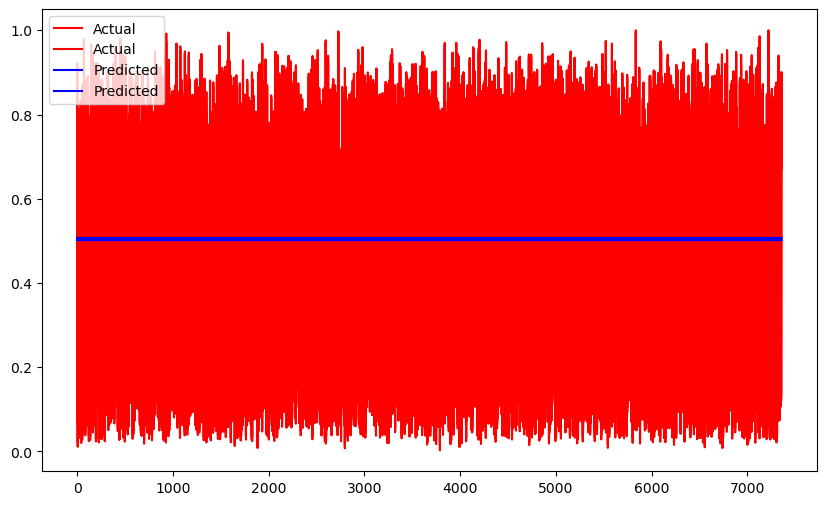

In [19]:
# making predictions
model.eval()
# Assuming you have a DataLoader for your test set named `test_loader`
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        out = model(X_batch)

        # Move predictions and labels back to CPU, convert them to numpy array
        predictions.append(out.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Concatenate all the batches into a single array
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actuals, 'r', label='Actual')
plt.plot(predictions, 'b', label='Predicted')
plt.legend()
plt.show()


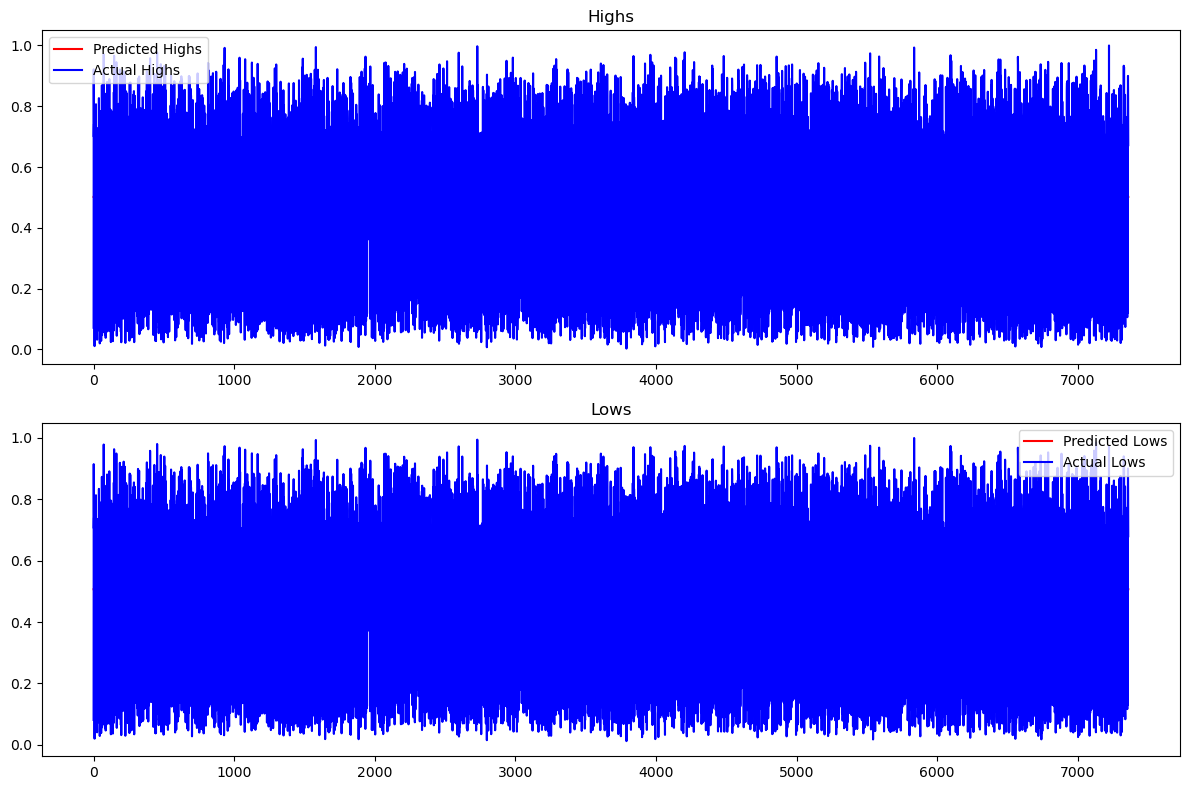

In [20]:
# Assume predictions is a 2D array with shape (n_samples, 2)
# where predictions[:, 0] are the predicted highs and
# predictions[:, 1] are the predicted lows
predicted_highs = predictions[:, 0]
predicted_lows = predictions[:, 1]

# Similarly for actuals
actual_highs = actuals[:, 0]
actual_lows = actuals[:, 1]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(predicted_highs, 'r', label='Predicted Highs')
ax[0].plot(actual_highs, 'b', label='Actual Highs')
ax[0].legend()
ax[0].set_title('Highs')

ax[1].plot(predicted_lows, 'r', label='Predicted Lows')
ax[1].plot(actual_lows, 'b', label='Actual Lows')
ax[1].legend()
ax[1].set_title('Lows')

plt.tight_layout()
plt.show()